In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import json
tfk  = tf .keras
tfkl = tfk.layers

from utils import *
from tf_dataset_load_custom import image_dataset_from_directory
from tqdm import tqdm

In [3]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing

#299 (addative)

dim = 128
def get_autoencoder_model1(img_width=dim, img_height=dim):
    
    autoencoder = Sequential()
    # Encoder
    autoencoder.add(InputLayer(input_shape=(img_width, img_height, 1)))
    autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    autoencoder.add(MaxPooling2D((2, 2), padding='same'))
    autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    autoencoder.add(MaxPooling2D((2, 2), padding='same'))
    # Decoder
    autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    autoencoder.summary()
    return autoencoder

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [88]:
path = "imgmin/computed-ig"
#path = "out"
import pickle 

objs = []
names = []
test = []

file1 = open("names.txt","w")

for i, item in enumerate(os.listdir(path)):
    with open(path+"/"+item, 'rb') as fp:
        obj = pickle.load(fp)
    names.append(item)
    file1.write(item+"\n")
    
    if i < 900:
        objs.append(obj)
    elif i > 900:
        test.append(obj)

    if i >= 1000:
        break
    
        
file1.close()
print(len(objs))
print(len(test))

900
100


(2, 1, 299, 299, 3)
Max value in  1.7016035
Min value in  -2.223907
[[ 0.00282975 -0.00220071 -0.01053343 ...  0.00462716 -0.00080966
   0.00120501]
 [-0.00338065 -0.01090877 -0.03219679 ...  0.01012594  0.00466903
  -0.0013431 ]
 [-0.00313408 -0.02210446 -0.02315128 ...  0.03274417  0.01353116
   0.01340195]
 ...
 [-0.01637584 -0.04530022 -0.08060446 ... -0.00453582 -0.02097975
  -0.01370036]
 [-0.00024272 -0.02949334 -0.05743854 ...  0.02981859  0.00298574
  -0.00559781]
 [-0.00309356 -0.01508632 -0.01508983 ... -0.00822129  0.00337892
   0.00190155]]


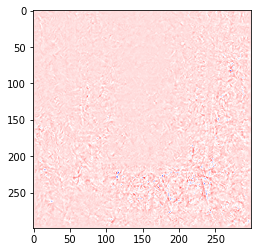

In [5]:
print(np.stack(obj["igs"]).shape)

img = np.concatenate(obj["igs"]).mean((0,-1))

for i,curr in enumerate(objs):
    objs[i] = np.concatenate(curr["igs"]).mean((0,-1))
    objs[i] = objs[i][:-3,:-3] #scale to 296
    #print(objs[i].shape)
    

for i,curr in enumerate(test):
    test[i] = np.concatenate(curr["igs"]).mean((0,-1))
    test[i] = test[i][:-3,:-3] #scale to 296
    #print(objs[i].shape)
    
print('Max value in ', img.max())
print('Min value in ', img.min())

print(img)

plt.imshow(img,cmap = "bwr")

Max value in  0.9923769
Min value in  -0.013218355
(900, 296, 296, 1) <class 'numpy.ndarray'>


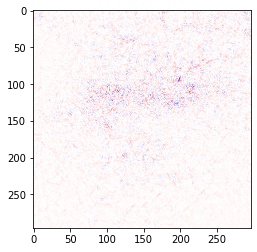

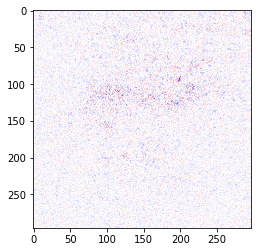

(900, 296, 296, 1)
(900, 296, 296, 1)


In [6]:
indata = np.array(objs)
indata = (indata[...,tf.newaxis] +10)/20

indata_test = np.array(test)
indata_test = (indata_test[...,tf.newaxis] +10)/20

print('Max value in ', indata[0].max())
print('Min value in ', indata[0].min())

indata_noise = indata.copy()

print(indata_noise.shape, type(indata_noise))

plt.imshow(indata_noise[0],cmap = "bwr")
plt.show()

#add gaussian noise
var = 0.05
indata_noise += np.random.normal(0, var, indata_noise.shape) 

indata = tf.clip_by_value(indata, clip_value_min=0., clip_value_max=1.)
indata_noise = tf.clip_by_value(indata_noise, clip_value_min=0., clip_value_max=1.)
indata_test = tf.clip_by_value(indata_test, clip_value_min=0., clip_value_max=1.)

plt.imshow(indata_noise[0],cmap = "bwr")
plt.show()

print(indata_noise.shape)
print(indata.shape)

In [10]:
bs=3
e=20

split =True
lr = 1e-6
validation_split=0.3

dim = 296

model = get_autoencoder_model1(dim,dim)

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss='mse')

if split ==True:
    model.fit(indata_noise, indata, epochs=e,batch_size=bs, validation_split=validation_split)
#else:
#    model.fit(x_train_noisy, x_train, epochs=e,batch_size=bs,shuffle=True, validation_data=(x_test_noisy, x_test))

pics = model.predict(indata_noise)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 296, 296, 64)      640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 148, 148, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 74, 74, 128)       147584    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 148, 148, 128)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 148, 148, 64)     

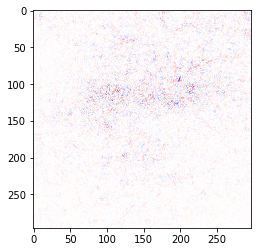

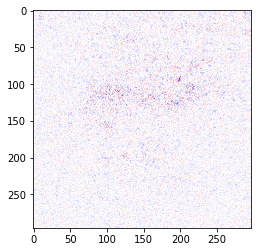

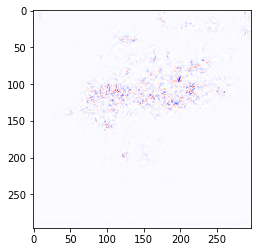

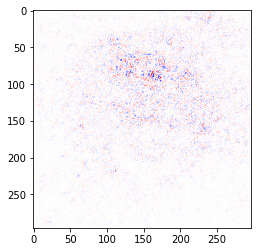

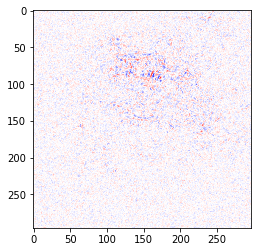

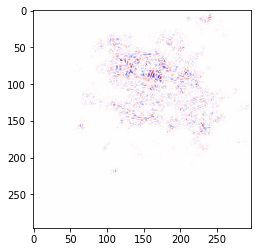

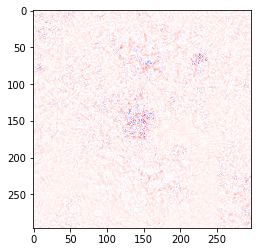

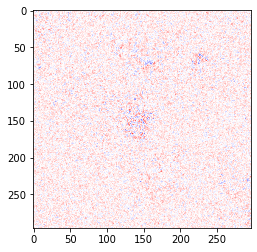

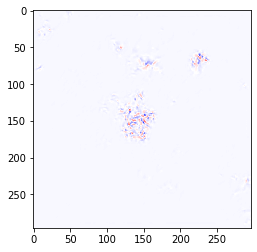

In [11]:
import matplotlib.pyplot as plt

pics = model.predict(indata)

n = 3 
for i in range(n): 
    plt.imshow(indata[i],cmap = "bwr")
    plt.show()
    plt.imshow(indata_noise[i],cmap = "bwr")
    plt.show()
    plt.imshow(pics[i],cmap = "bwr")
    plt.show()

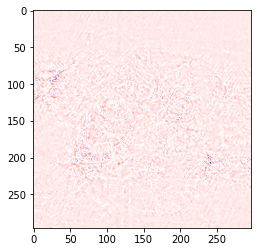

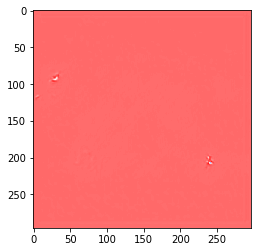

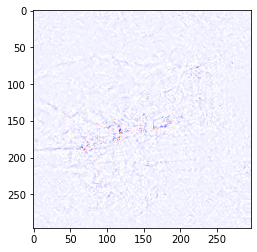

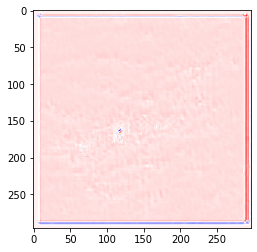

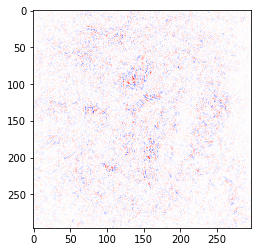

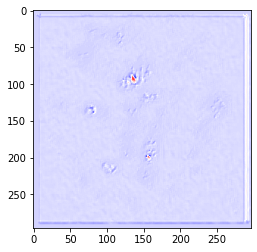

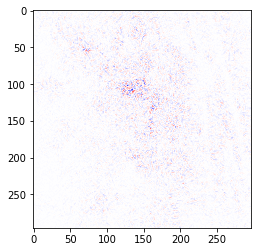

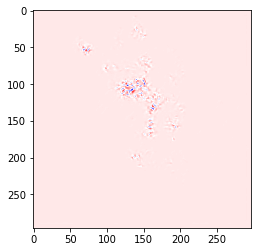

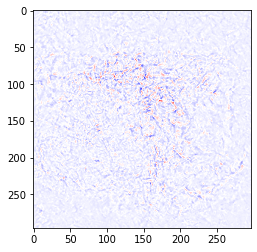

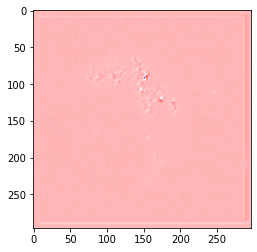

In [12]:
#run on test data

pics_test = model.predict(indata_test)

n = 5 
for i in range(n): 
    plt.imshow(indata_test[i],cmap = "bwr")
    plt.show()
    plt.imshow(pics_test[i],cmap = "bwr")
    plt.show()

In [44]:
index = 5
imgs = []
for i in range(1000):
    img = io_ops.read_file("picsig/" + files_jpg[i])
    img = image_ops.decode_image(
        img, 
        channels = 3, 
        expand_animations = False)
    imgs.append(image_ops.resize_images_v2(
        img, 
        (296, 296), 
        method = image_preprocessing.get_interpolation('bilinear')))

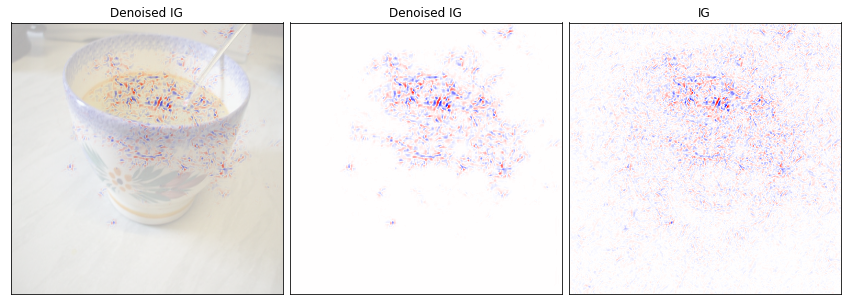

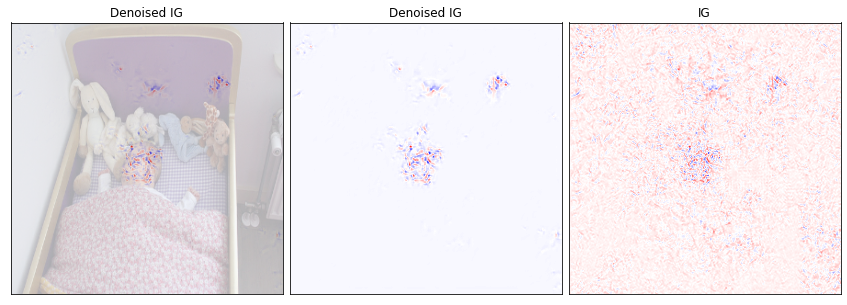

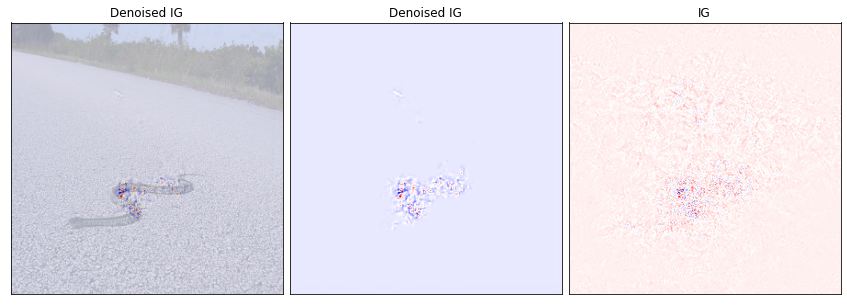

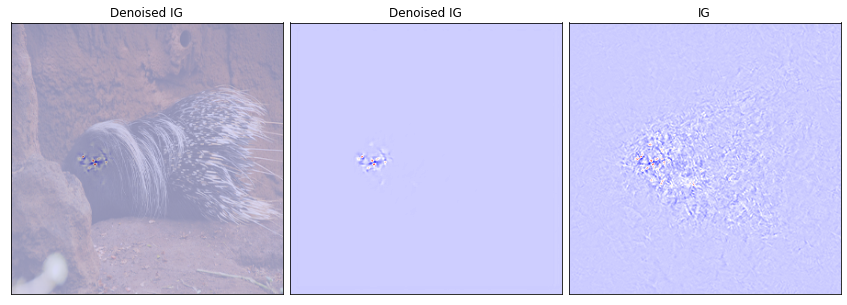

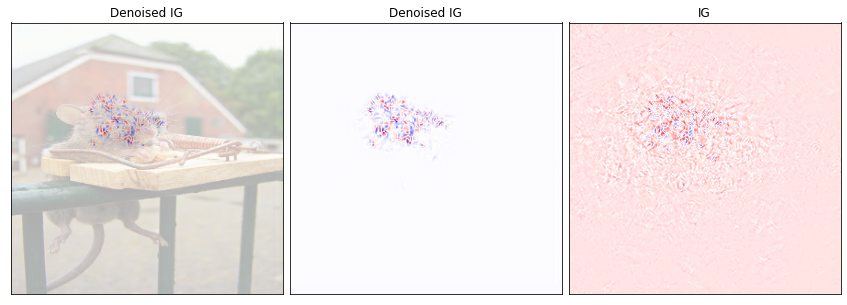

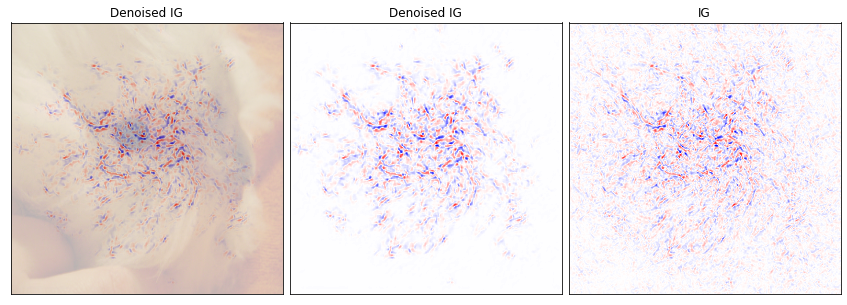

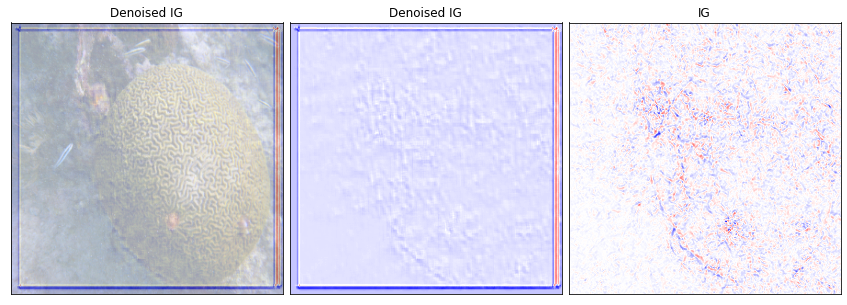

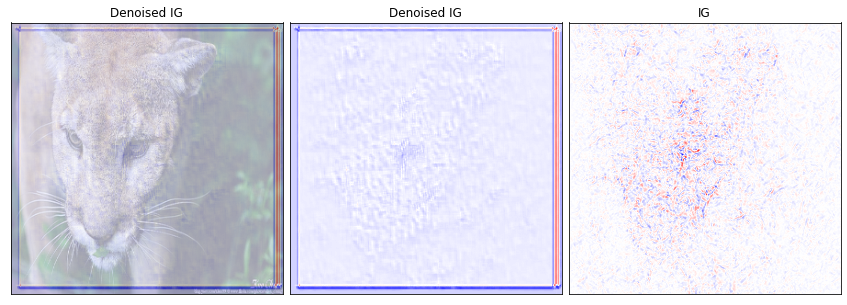

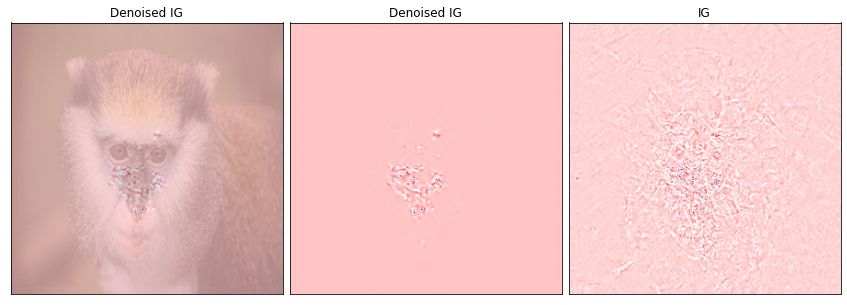

In [110]:
for i in range(1,10):
    plt.figure(figsize = (15, 5))
    plt.subplots_adjust(wspace = 0.)
    plt.subplot(1, 3, 1)
    plt.title("Denoised IG")
    plt.imshow(np.array(imgs[i])/256)
    plt.imshow(pics[i], alpha = 0.7,cmap = "bwr" )
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1, 3, 2)
    plt.title("Denoised IG")
    plt.imshow(pics[i],cmap = "bwr")
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1, 3, 3)
    plt.title("IG")
    plt.imshow(indata[i],cmap = "bwr")
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    

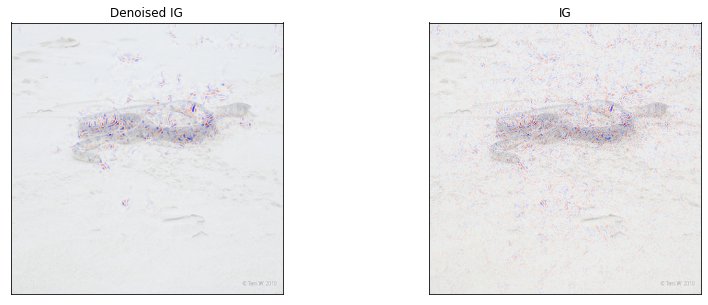

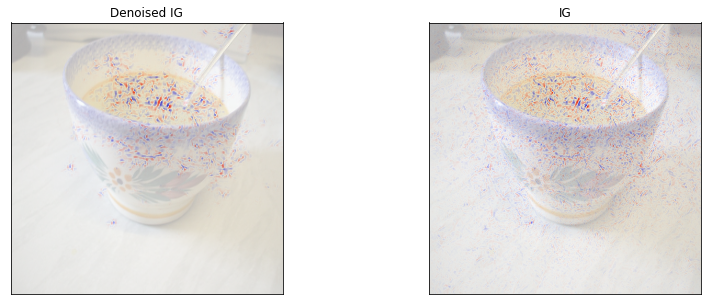

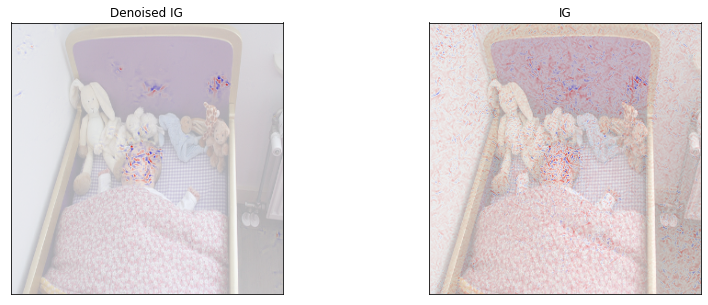

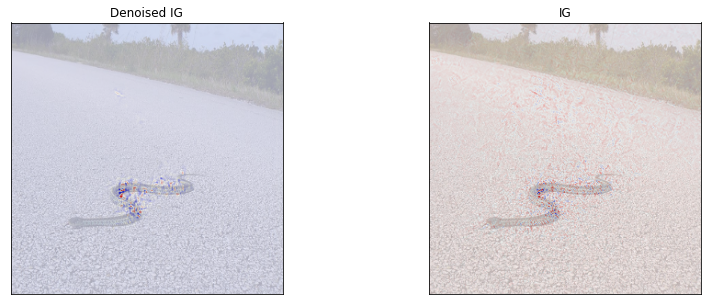

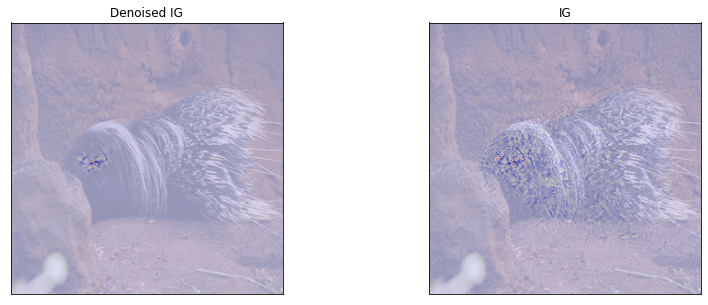

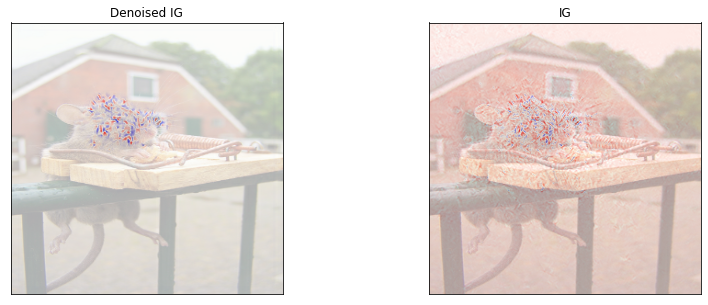

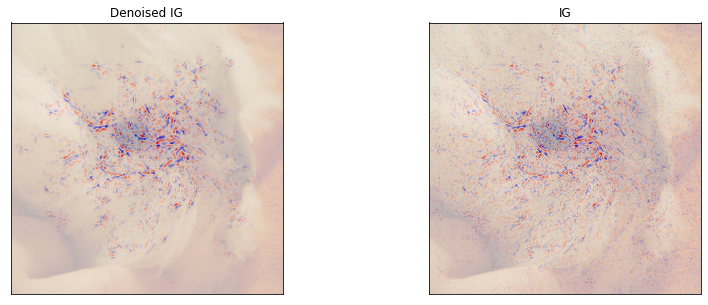

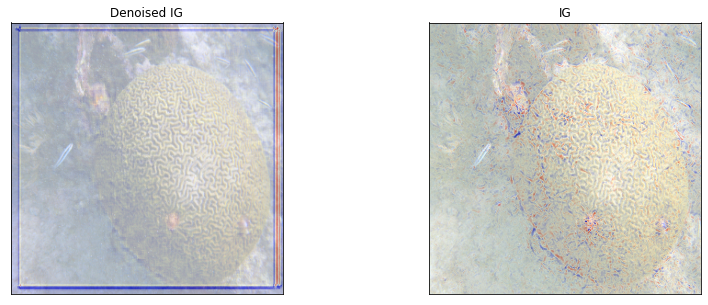

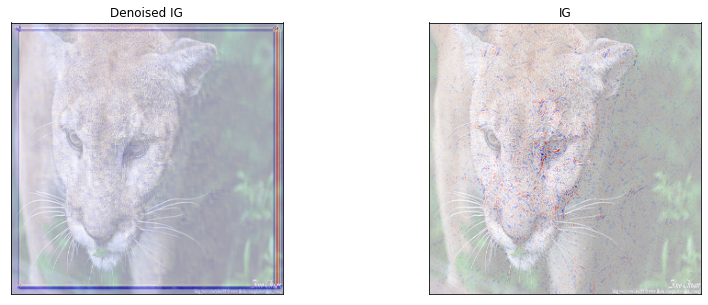

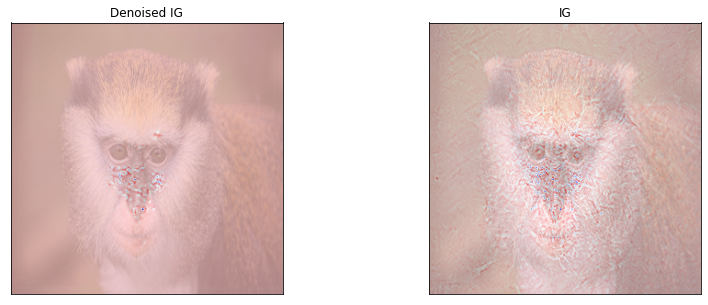

In [111]:
for i in range(10):
    plt.figure(figsize = (15, 5))
    plt.subplots_adjust(wspace = 0.)
    plt.subplot(1, 2, 1)
    plt.title("Denoised IG")
    plt.imshow(np.array(imgs[i])/256)
    plt.imshow(pics[i], alpha = 0.7,cmap = "bwr" )
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1, 2, 2)
    plt.title("IG")
    plt.imshow(np.array(imgs[i])/256)
    plt.imshow(indata[i], alpha = 0.7,cmap = "bwr" )
    plt.xticks([])
    plt.yticks([])

    
    plt.show()

In [56]:
classifer = tf.keras.applications.InceptionV3()

from insertion_deletion import *

klen = 11
ksig = 5
kern = gkern(klen, ksig)
blur = lambda x: torch.nn.functional.conv2d(x, kern, padding=klen//2)

insertion = CausalMetric(classifer, 'ins', 2000, substrate_fn = blur)
deletion  = CausalMetric(classifer, 'del', 2000, substrate_fn = torch.zeros_like)

In [127]:
i = 0

resfile = open("results_denoise.txt","w")

resfile.write("insertion IG" + "," + "deletion IG"+ "," +"insertion denoised"+ "," +"deletion denoised"+ "\n")

iig = []
dig = []
iig2 = []
dig2 = []

for i in range(900):
    img2 = image_ops.resize_images_v2(
                imgs[i], 
                (299, 299), 
                method = image_preprocessing.get_interpolation('bilinear'))

    img2 = tf.keras.applications.inception_v3.preprocess_input(img2)

    ig = image_ops.resize_images_v2(
                indata[i], 
                (299, 299), 
                method = image_preprocessing.get_interpolation('bilinear'))

    ig2 = image_ops.resize_images_v2(
                pics[i], 
                (299, 299), 
                method = image_preprocessing.get_interpolation('bilinear'))
    print(names[i], "itter", i)
    
    inig = insertion.single_run(img2[tf.newaxis],ig.numpy())
    delig = deletion.single_run(img2[tf.newaxis],ig.numpy())
    
    inig2 = insertion.single_run(img2[tf.newaxis],ig2.numpy())
    delig2 = deletion.single_run(img2[tf.newaxis],ig2.numpy())
    
    iig.append(inig)
    dig.append(delig)
    iig2.append(inig2)
    dig2.append(delig2)
    
    print("insertion IG", inig)
    print("deletion IG", delig)

    print("insertion denoised", inig2)
    print("deletion denoised", delig2)
    
    resfile.write(str(inig) + "," + str(delig)+ "," +str(inig2)+ "," +str(delig2)+ "\n")

resfile.close()
    

ILSVRC2012_val_00000001.jpg.pickle itter 0
insertion IG 0.8178081578678555
deletion IG 0.37095670452399643
insertion denoised 0.8569491523835394
deletion denoised 0.05895634189332163
ILSVRC2012_val_00000004.jpg.pickle itter 1
insertion IG 0.3514502024485005
deletion IG 0.032759133256169866
insertion denoised 0.2802033303512467
deletion denoised 0.046243228198727594
ILSVRC2012_val_00000005.jpg.pickle itter 2
insertion IG 0.36155820321162335
deletion IG 0.06701928421736941
insertion denoised 0.4723225813772943
deletion denoised 0.04896605252078087
ILSVRC2012_val_00000006.jpg.pickle itter 3
insertion IG 0.5344799101197472
deletion IG 0.2242630058870418
insertion denoised 0.6124160030753248
deletion denoised 0.0829040584746205
ILSVRC2012_val_00000007.jpg.pickle itter 4
insertion IG 0.42148566628263023
deletion IG 0.0887058423859748
insertion denoised 0.4547053606689183
deletion denoised 0.30194562452083523
ILSVRC2012_val_00000009.jpg.pickle itter 5
insertion IG 0.5915121461200114
deletion 

insertion IG 0.14958260046680355
deletion IG 0.029787754750092668
insertion denoised 0.1562314786379122
deletion denoised 0.0779751716253587
ILSVRC2012_val_00000062.jpg.pickle itter 46
insertion IG 0.36762269836746986
deletion IG 0.02784028042773975
insertion denoised 0.11783651493670833
deletion denoised 0.0233840890836695
ILSVRC2012_val_00000063.jpg.pickle itter 47
insertion IG 0.7685602307319641
deletion IG 0.06594937446821456
insertion denoised 0.8404511908690134
deletion denoised 0.09553010675978536
ILSVRC2012_val_00000066.jpg.pickle itter 48
insertion IG 0.6747446599002513
deletion IG 0.04650487055526658
insertion denoised 0.2971917178740518
deletion denoised 0.01988834415775879
ILSVRC2012_val_00000067.jpg.pickle itter 49
insertion IG 0.6899430656094208
deletion IG 0.42796121366280004
insertion denoised 0.5875905382503536
deletion denoised 0.4190031917878514
ILSVRC2012_val_00000068.jpg.pickle itter 50
insertion IG 0.290867283555983
deletion IG 0.1968822821123063
insertion denoise

insertion IG 0.9588059034612444
deletion IG 0.8049955758508683
insertion denoised 0.7320726524210639
deletion denoised 0.5504169247218266
ILSVRC2012_val_00000122.jpg.pickle itter 91
insertion IG 0.4282370145639612
deletion IG 0.04703245328273624
insertion denoised 0.4213847363471157
deletion denoised 0.07729069967123602
ILSVRC2012_val_00000123.jpg.pickle itter 92
insertion IG 0.9468932613730431
deletion IG 0.11399052693353345
insertion denoised 0.8205426439823996
deletion denoised 0.11853997395729594
ILSVRC2012_val_00000125.jpg.pickle itter 93
insertion IG 0.020267457592854043
deletion IG 0.007640970971584061
insertion denoised 0.012989529396953811
deletion denoised 0.007837721978689337
ILSVRC2012_val_00000126.jpg.pickle itter 94
insertion IG 0.07679651081028473
deletion IG 0.01361489993615679
insertion denoised 0.1520590175329643
deletion denoised 0.12411166626310054
ILSVRC2012_val_00000127.jpg.pickle itter 95
insertion IG 0.3046364871992005
deletion IG 0.06533770873874245
insertion d

insertion IG 0.9476153055826823
deletion IG 0.06576325943080721
insertion denoised 0.880327926741706
deletion denoised 0.7335412434352394
ILSVRC2012_val_00000178.jpg.pickle itter 136
insertion IG 0.21364694684743882
deletion IG 0.06089900551774513
insertion denoised 0.23156099311179584
deletion denoised 0.41752621060089345
ILSVRC2012_val_00000179.jpg.pickle itter 137
insertion IG 0.9024123258060879
deletion IG 0.09964828790956139
insertion denoised 0.7317384927637047
deletion denoised 0.11067655289225513
ILSVRC2012_val_00000183.jpg.pickle itter 138
insertion IG 0.8766854412025875
deletion IG 0.030343700542208453
insertion denoised 0.9363042996989356
deletion denoised 0.07742307147176082
ILSVRC2012_val_00000184.jpg.pickle itter 139
insertion IG 0.08880045475024316
deletion IG 0.043571651998354353
insertion denoised 0.08125159811849396
deletion denoised 0.06346792401390201
ILSVRC2012_val_00000185.jpg.pickle itter 140
insertion IG 0.1208457828965038
deletion IG 0.025170293449627935
insert

insertion IG 0.7899232705434164
deletion IG 0.3488372782582802
insertion denoised 0.7897923648357391
deletion denoised 0.5149106954046551
ILSVRC2012_val_00000234.jpg.pickle itter 181
insertion IG 0.8718096224798096
deletion IG 0.2036318601453483
insertion denoised 0.7285882447328832
deletion denoised 0.653828242169402
ILSVRC2012_val_00000235.jpg.pickle itter 182
insertion IG 0.8434767411814795
deletion IG 0.5504569191212391
insertion denoised 0.6998262753089269
deletion denoised 0.4119150972288076
ILSVRC2012_val_00000236.jpg.pickle itter 183
insertion IG 0.1628668500071702
deletion IG 0.004617901761109048
insertion denoised 0.12239850552157602
deletion denoised 0.011095901741585597
ILSVRC2012_val_00000237.jpg.pickle itter 184
insertion IG 0.4424026625023948
deletion IG 0.02370893661864102
insertion denoised 0.2613800398177571
deletion denoised 0.02378659601155151
ILSVRC2012_val_00000238.jpg.pickle itter 185
insertion IG 0.09598106867310384
deletion IG 0.00811876598143297
insertion deno

insertion IG 0.5238353053728739
deletion IG 0.04541672893424725
insertion denoised 0.542907738023334
deletion denoised 0.10989612409482813
ILSVRC2012_val_00000288.jpg.pickle itter 226
insertion IG 0.737751367357042
deletion IG 0.18325515872533693
insertion denoised 0.7621303651067945
deletion denoised 0.19923479997329802
ILSVRC2012_val_00000289.jpg.pickle itter 227
insertion IG 0.3330161710166269
deletion IG 0.02911335392735863
insertion denoised 0.5393756810989645
deletion denoised 0.04972672205387628
ILSVRC2012_val_00000291.jpg.pickle itter 228
insertion IG 0.13037022149009217
deletion IG 0.013316920681083705
insertion denoised 0.16745965258192477
deletion denoised 0.016553565405340327
ILSVRC2012_val_00000294.jpg.pickle itter 229
insertion IG 0.4899222936123907
deletion IG 0.09869740222553341
insertion denoised 0.33361057618927187
deletion denoised 0.231531452878749
ILSVRC2012_val_00000297.jpg.pickle itter 230
insertion IG 0.014193972448912165
deletion IG 0.003412005989634458
inserti

insertion IG 0.2534381948411465
deletion IG 0.08209019209300297
insertion denoised 0.3149576074547238
deletion denoised 0.5054046255557397
ILSVRC2012_val_00000354.jpg.pickle itter 271
insertion IG 0.5169670490754975
deletion IG 0.13295459140354068
insertion denoised 0.7129213492903445
deletion denoised 0.14907158412679564
ILSVRC2012_val_00000355.jpg.pickle itter 272
insertion IG 0.9097189048926035
deletion IG 0.04137081666154296
insertion denoised 0.8574733297030132
deletion denoised 0.1066376832281498
ILSVRC2012_val_00000356.jpg.pickle itter 273
insertion IG 0.5521896867288484
deletion IG 0.12120892899838509
insertion denoised 0.29625934552815225
deletion denoised 0.07291992894202445
ILSVRC2012_val_00000357.jpg.pickle itter 274
insertion IG 0.9228003819783529
deletion IG 0.1826761629653548
insertion denoised 0.7361894606302182
deletion denoised 0.09408450463799656
ILSVRC2012_val_00000358.jpg.pickle itter 275
insertion IG 0.6247169952425692
deletion IG 0.023985414450483706
insertion de

insertion IG 0.7119442279114284
deletion IG 0.22652513446632333
insertion denoised 0.6423253404254663
deletion denoised 0.31553417066590755
ILSVRC2012_val_00000405.jpg.pickle itter 316
insertion IG 0.9132459228677261
deletion IG 0.13747704179897685
insertion denoised 0.7748324989056629
deletion denoised 0.40587331546913546
ILSVRC2012_val_00000406.jpg.pickle itter 317
insertion IG 0.9132856667041779
deletion IG 0.040498007446411875
insertion denoised 0.9297898723019494
deletion denoised 0.2577187144547376
ILSVRC2012_val_00000407.jpg.pickle itter 318
insertion IG 0.9005794436567359
deletion IG 0.3494493220137277
insertion denoised 0.39110227186853685
deletion denoised 0.7392651057653388
ILSVRC2012_val_00000409.jpg.pickle itter 319
insertion IG 0.7014515214496189
deletion IG 0.09123418077277974
insertion denoised 0.7630689137511784
deletion denoised 0.15635938342182068
ILSVRC2012_val_00000410.jpg.pickle itter 320
insertion IG 0.06343321111894006
deletion IG 0.07225691676758288
insertion d

insertion IG 0.9894592500395245
deletion IG 0.24941072881119908
insertion denoised 0.9552417132589552
deletion denoised 0.5678486859894798
ILSVRC2012_val_00000461.jpg.pickle itter 361
insertion IG 0.09640629380010068
deletion IG 0.02129618007182014
insertion denoised 0.24803300283124877
deletion denoised 0.11415934098848891
ILSVRC2012_val_00000462.jpg.pickle itter 362
insertion IG 0.833608865737915
deletion IG 0.04130252659961116
insertion denoised 0.6206741518444485
deletion denoised 0.07538707050108416
ILSVRC2012_val_00000463.jpg.pickle itter 363
insertion IG 0.857108369241986
deletion IG 0.06783555783072694
insertion denoised 0.7878057547120585
deletion denoised 0.13819986025175443
ILSVRC2012_val_00000464.jpg.pickle itter 364
insertion IG 0.04056219556110187
deletion IG 0.005771691171725656
insertion denoised 0.02782594683683581
deletion denoised 0.006102995859934405
ILSVRC2012_val_00000465.jpg.pickle itter 365
insertion IG 0.8224033928579755
deletion IG 0.18891506937539412
insertio

insertion IG 0.2682569595150805
deletion IG 0.13809348160931323
insertion denoised 0.26920980855292226
deletion denoised 0.2023229974593657
ILSVRC2012_val_00000511.jpg.pickle itter 406
insertion IG 0.35262264385819436
deletion IG 0.08169483426795018
insertion denoised 0.43400778787003624
deletion denoised 0.09049922942536391
ILSVRC2012_val_00000512.jpg.pickle itter 407
insertion IG 0.4329557969338364
deletion IG 0.12256338496032791
insertion denoised 0.38545282541664266
deletion denoised 0.29000675959153643
ILSVRC2012_val_00000514.jpg.pickle itter 408
insertion IG 0.08934475536872115
deletion IG 0.01801622523667498
insertion denoised 0.11503382577003422
deletion denoised 0.04025914321052066
ILSVRC2012_val_00000515.jpg.pickle itter 409
insertion IG 0.20149617032147943
deletion IG 0.04056387542331221
insertion denoised 0.33604148553891316
deletion denoised 0.18810542060244997
ILSVRC2012_val_00000518.jpg.pickle itter 410
insertion IG 0.268142239972561
deletion IG 0.008053258001382346
inse

insertion IG 0.7452331632375717
deletion IG 0.7116993989527448
insertion denoised 0.6696460559550259
deletion denoised 0.5400115623777917
ILSVRC2012_val_00000568.jpg.pickle itter 451
insertion IG 0.19879544816083378
deletion IG 0.07024405464568796
insertion denoised 0.09537865068349573
deletion denoised 0.03733506249328558
ILSVRC2012_val_00000569.jpg.pickle itter 452
insertion IG 0.6988139424059127
deletion IG 0.1224116843737041
insertion denoised 0.7076757219102647
deletion denoised 0.2557967052403708
ILSVRC2012_val_00000570.jpg.pickle itter 453
insertion IG 0.2817263424415917
deletion IG 0.010856618395337136
insertion denoised 0.21943398232817546
deletion denoised 0.010978901722895291
ILSVRC2012_val_00000571.jpg.pickle itter 454
insertion IG 0.9538638903035058
deletion IG 0.4366132294979858
insertion denoised 0.9865273442533281
deletion denoised 0.5236646170556519
ILSVRC2012_val_00000572.jpg.pickle itter 455
insertion IG 0.18703585950036844
deletion IG 0.013228036640955704
insertion 

insertion IG 0.0830173970206589
deletion IG 0.15402540673785553
insertion denoised 0.07903140870079774
deletion denoised 0.015539120794791314
ILSVRC2012_val_00000624.jpg.pickle itter 496
insertion IG 0.13091376024013798
deletion IG 0.046643174298676766
insertion denoised 0.2935282671508806
deletion denoised 0.05573404111912371
ILSVRC2012_val_00000625.jpg.pickle itter 497
insertion IG 0.8226710120836894
deletion IG 0.15437589453770972
insertion denoised 0.788688596089681
deletion denoised 0.18288493434374686
ILSVRC2012_val_00000626.jpg.pickle itter 498
insertion IG 0.19500320453274375
deletion IG 0.11553985470608394
insertion denoised 0.27667697657598184
deletion denoised 0.4880319331544645
ILSVRC2012_val_00000628.jpg.pickle itter 499
insertion IG 0.7161699722417527
deletion IG 0.15844335287785927
insertion denoised 0.6300706722980572
deletion denoised 0.4312092868743801
ILSVRC2012_val_00000629.jpg.pickle itter 500
insertion IG 0.9824389755725861
deletion IG 0.7099798048063855
insertion

insertion IG 0.03994155769339866
deletion IG 0.018726176735779317
insertion denoised 0.047209711137434676
deletion denoised 0.014140492824339566
ILSVRC2012_val_00000679.jpg.pickle itter 541
insertion IG 0.6913560264640384
deletion IG 0.21881018120824997
insertion denoised 0.7135129696793027
deletion denoised 0.3088065510902703
ILSVRC2012_val_00000680.jpg.pickle itter 542
insertion IG 0.012109815811385892
deletion IG 0.008053634274215762
insertion denoised 0.013904028553649065
deletion denoised 0.008221289957509726
ILSVRC2012_val_00000681.jpg.pickle itter 543
insertion IG 0.9119090764058961
deletion IG 0.4036778839546767
insertion denoised 0.9741158346335094
deletion denoised 0.3429942548716402
ILSVRC2012_val_00000682.jpg.pickle itter 544
insertion IG 0.17720090558545457
deletion IG 0.06877344489734646
insertion denoised 0.27071500374262947
deletion denoised 0.2870874303976759
ILSVRC2012_val_00000685.jpg.pickle itter 545
insertion IG 0.6504284421602885
deletion IG 0.10242877533439443
in

insertion IG 0.7191911488771439
deletion IG 0.7496049216033296
insertion denoised 0.5297135623792807
deletion denoised 0.4421572820471839
ILSVRC2012_val_00000736.jpg.pickle itter 586
insertion IG 0.9957513213157654
deletion IG 0.11933008682349787
insertion denoised 0.8891789231035444
deletion denoised 0.06916320843605112
ILSVRC2012_val_00000737.jpg.pickle itter 587
insertion IG 0.255356908051504
deletion IG 0.09702453883397134
insertion denoised 0.48778093356328706
deletion denoised 0.031510362851097144
ILSVRC2012_val_00000738.jpg.pickle itter 588
insertion IG 0.4224286547732643
deletion IG 0.2913991694883104
insertion denoised 0.40009591581183485
deletion denoised 0.13309589619247061
ILSVRC2012_val_00000739.jpg.pickle itter 589
insertion IG 0.9215136885643005
deletion IG 0.1896328553822564
insertion denoised 0.8782671835687426
deletion denoised 0.6131953263185601
ILSVRC2012_val_00000740.jpg.pickle itter 590
insertion IG 0.055643495487877066
deletion IG 0.017112037911020807
insertion d

insertion IG 0.847703890171316
deletion IG 0.19621418452516082
insertion denoised 0.7824532545275158
deletion denoised 0.19056679163630988
ILSVRC2012_val_00000788.jpg.pickle itter 631
insertion IG 0.4313409720185316
deletion IG 0.025347809680008344
insertion denoised 0.4615482341912058
deletion denoised 0.016218800004996106
ILSVRC2012_val_00000790.jpg.pickle itter 632
insertion IG 0.22955122391382854
deletion IG 0.01812177693694442
insertion denoised 0.28180322480232767
deletion denoised 0.015522495621634233
ILSVRC2012_val_00000791.jpg.pickle itter 633
insertion IG 0.018274675286374987
deletion IG 0.037406022624862895
insertion denoised 0.01997758434897858
deletion denoised 0.10909866046697264
ILSVRC2012_val_00000792.jpg.pickle itter 634
insertion IG 0.2574557327768869
deletion IG 0.010917661854263214
insertion denoised 0.2697051899507642
deletion denoised 0.013481173468850709
ILSVRC2012_val_00000793.jpg.pickle itter 635
insertion IG 0.7874734368589189
deletion IG 0.09432331617762328
i

insertion IG 0.789868579308192
deletion IG 0.1879721669429273
insertion denoised 0.9204878085189395
deletion denoised 0.4876546347313706
ILSVRC2012_val_00000843.jpg.pickle itter 676
insertion IG 0.008203337518372994
deletion IG 0.0014072203315562445
insertion denoised 0.008683119845328394
deletion denoised 0.0015761294437753451
ILSVRC2012_val_00000844.jpg.pickle itter 677
insertion IG 0.8884181247817146
deletion IG 0.035291303322648876
insertion denoised 0.9652162737316555
deletion denoised 0.06495990350728485
ILSVRC2012_val_00000846.jpg.pickle itter 678
insertion IG 0.09861317112938398
deletion IG 0.015871371666435152
insertion denoised 0.12469424515083018
deletion denoised 0.013745336838716564
ILSVRC2012_val_00000847.jpg.pickle itter 679
insertion IG 0.49320497903972865
deletion IG 0.04262387470083316
insertion denoised 0.2782139857713547
deletion denoised 0.24484478916710942
ILSVRC2012_val_00000849.jpg.pickle itter 680
insertion IG 0.35772027859671246
deletion IG 0.1916371208016547


insertion IG 0.44560358526392113
deletion IG 0.1649323491780605
insertion denoised 0.5286593546470006
deletion denoised 0.22633208755440945
ILSVRC2012_val_00000895.jpg.pickle itter 721
insertion IG 0.5178409631053607
deletion IG 0.6501873365797413
insertion denoised 0.7091233473685052
deletion denoised 0.7601689037039048
ILSVRC2012_val_00000896.jpg.pickle itter 722
insertion IG 0.01064472273234666
deletion IG 0.004188458168694827
insertion denoised 0.010565857163520478
deletion denoised 0.0032555110671940684
ILSVRC2012_val_00000897.jpg.pickle itter 723
insertion IG 0.03808883529725588
deletion IG 0.002421396344127263
insertion denoised 0.05120376565804084
deletion denoised 0.0035787142342693793
ILSVRC2012_val_00000898.jpg.pickle itter 724
insertion IG 0.3676753168679877
deletion IG 0.0860541047474827
insertion denoised 0.4217269644425768
deletion denoised 0.11000078378193494
ILSVRC2012_val_00000900.jpg.pickle itter 725
insertion IG 0.6637272968862413
deletion IG 0.24842715504605117
ins

insertion IG 0.38241333253164256
deletion IG 0.09391741787904821
insertion denoised 0.23366434934238592
deletion denoised 0.11874760669484709
ILSVRC2012_val_00000951.jpg.pickle itter 766
insertion IG 0.8660399798821244
deletion IG 0.39834166825813655
insertion denoised 0.6580196772908999
deletion denoised 0.17342618955307343
ILSVRC2012_val_00000952.jpg.pickle itter 767
insertion IG 0.9612015220854018
deletion IG 0.1405992837959881
insertion denoised 0.9244311743312412
deletion denoised 0.08349526319830652
ILSVRC2012_val_00000954.jpg.pickle itter 768
insertion IG 0.5207479397455851
deletion IG 0.04922448588072762
insertion denoised 0.5827124612198935
deletion denoised 0.014515396372654423
ILSVRC2012_val_00000955.jpg.pickle itter 769
insertion IG 0.19736662358045579
deletion IG 0.009821607181462848
insertion denoised 0.07172203674563207
deletion denoised 0.013837886508796752
ILSVRC2012_val_00000956.jpg.pickle itter 770
insertion IG 0.5390698206481628
deletion IG 0.07015401692794208
inser

insertion IG 0.32635842894928324
deletion IG 0.11679894236407967
insertion denoised 0.3489100716594193
deletion denoised 0.36916497294312445
ILSVRC2012_val_00001005.jpg.pickle itter 811
insertion IG 0.9547920048236846
deletion IG 0.011119836295242496
insertion denoised 0.8769691871272193
deletion denoised 0.016671712609887538
ILSVRC2012_val_00001006.jpg.pickle itter 812
insertion IG 0.09912343884093894
deletion IG 0.04403312384545441
insertion denoised 0.08897787483616007
deletion denoised 0.04171621687692095
ILSVRC2012_val_00001007.jpg.pickle itter 813
insertion IG 0.544787674001418
deletion IG 0.21164077003931098
insertion denoised 0.3139904831355024
deletion denoised 0.31373027325866537
ILSVRC2012_val_00001008.jpg.pickle itter 814
insertion IG 0.0522901028624296
deletion IG 0.031526159228427116
insertion denoised 0.06286233726423233
deletion denoised 0.0934000408388076
ILSVRC2012_val_00001009.jpg.pickle itter 815
insertion IG 0.7796805548895565
deletion IG 0.1567861075496896
inserti

insertion IG 0.27463440572222075
deletion IG 0.19641538081009963
insertion denoised 0.40491542634036803
deletion denoised 0.46448722449018126
ILSVRC2012_val_00001054.jpg.pickle itter 856
insertion IG 0.8772319353289074
deletion IG 0.10419428761878054
insertion denoised 0.7311468293269475
deletion denoised 0.6500100297723191
ILSVRC2012_val_00001055.jpg.pickle itter 857
insertion IG 0.6062960048516591
deletion IG 0.2298233303043364
insertion denoised 0.8641734778881073
deletion denoised 0.3227737955213039
ILSVRC2012_val_00001057.jpg.pickle itter 858
insertion IG 0.6960177209642199
deletion IG 0.09549236217672943
insertion denoised 0.5977006918854184
deletion denoised 0.14836364797083662
ILSVRC2012_val_00001058.jpg.pickle itter 859
insertion IG 0.9137184000677533
deletion IG 0.061640195057568944
insertion denoised 0.6695918330715762
deletion denoised 0.08317893029953767
ILSVRC2012_val_00001059.jpg.pickle itter 860
insertion IG 0.8588695896996392
deletion IG 0.4105549265917135
insertion de

In [129]:
import statistics as s

print(iig)

print(s.mean(iig), s.mean(dig), s.mean(iig2), s.mean(dig2))

[0.8178081578678555, 0.3514502024485005, 0.36155820321162335, 0.5344799101197472, 0.42148566628263023, 0.5915121461200114, 0.5414772725767559, 0.7076978198356099, 0.8202655010753208, 0.8623796996143129, 0.8586837506956524, 0.01414047936729427, 0.7993485706340936, 0.7831147409975528, 0.46534187336348826, 0.48834284364420455, 0.9752130130926768, 0.9465820709864299, 0.32250193039265773, 0.26146890232339504, 0.7350031885835859, 0.4845646688921584, 0.006912007753594985, 0.9438548905981912, 0.5185387015342713, 0.14087012369806567, 0.8109919753339555, 0.7812953467584318, 0.8059585253397624, 0.0740785932349455, 0.5064544109834566, 0.5413567264874776, 0.16603403389453888, 0.37709581495987043, 0.08235088569603653, 0.9623790568775601, 0.05358809615071449, 0.5411175605918591, 0.9200216948986053, 0.8404640511506134, 0.8253819624582927, 0.2609263747749436, 0.9677472445699904, 0.7522811179359754, 0.06554141447349038, 0.14958260046680355, 0.36762269836746986, 0.7685602307319641, 0.6747446599002513, 0.

In [26]:
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing
img = image_ops.resize_images_v2(
            img, 
            (299, 299), 
            method = image_preprocessing.get_interpolation('bilinear')
        )



In [15]:
p_xml = 'xmlig'
p_jpg = 'picsig'
files_xml = sorted(os.listdir(p_xml))
files_jpg = sorted(os.listdir(p_jpg))

with open('imagenet_class_index.json', 'r') as fp:
    label_json = json.loads(fp.read())
labels = np.array([
    [k, *v]
    for k, v in label_json.items()
])


In [10]:
print(pics.shape)
print(pics[0][:,:,0].shape)


as_string = tf.io.read_file(xml)
vals = tf.gather(tf.strings.split(as_string, '\n'), [7, 8, 18, 19, 20, 21])
vals = tf.strings.regex_replace(vals, '[^0123456789]', '')
vals = tf.strings.to_number(vals, tf.int32)

xmin, xmax, ymin, ymax = (
np.round(296 * vals[2] / vals[0]),
np.round(296 * vals[4] / vals[0]),
np.round(296 * vals[3] / vals[1]),
np.round(296 * vals[5] / vals[1]),)

def bbox_plot(ax, xmin, xmax, ymin, ymax):
    ax.plot([xmin, xmax], [ymin, ymin], 'r')
    ax.plot([xmin, xmin], [ymin, ymax], 'r')
    ax.plot([xmin, xmax], [ymax, ymax], 'r')
    ax.plot([xmax, xmax], [ymin, ymax], 'r')
        

(1002, 296, 296, 1)
(296, 296)


NameError: name 'xml' is not defined

In [19]:
# Compute AUROC
qs = np.linspace(1, 0, 6)

idxs = np.array([
    (idx, jdx)
    for idx in range(296)
    for jdx in range(296)
])

inbox = lambda samples, xmin, xmax, ymin, ymax: (
    (samples > [xmin, ymin]) & 
    (samples < [xmax, ymax])
).all(1)

attr = pics[2][:,:,0]

res_auc = []
res_insertion = []
res_deletion  = []

auc_ = []
for q in qs:

    positive_attr = np.concatenate([
        idxs, 
        tf.gather_nd(attr, idxs).numpy()[:, np.newaxis]
    ], 1)
    positive_attr = positive_attr[positive_attr[:, 2] > -1e-10]

    pos = np.argwhere(positive_attr[:, 2] >= np.quantile(positive_attr[:, 2], q)).flatten()
    neg = np.argwhere(positive_attr[:, 2] <  np.quantile(positive_attr[:, 2], q)).flatten()
    TP = inbox(positive_attr[pos, :2], xmin, xmax, ymin, ymax)
    FP = ~TP
    FN = inbox(positive_attr[neg, :2], xmin, xmax, ymin, ymax)
    TN = ~FN

    TP = TP.sum()
    TN = TN.sum()
    FP = FP.sum()
    FN = FN.sum()

    auc_.append((FP / (FP + TN), TP / (TP + FN)))

    auc_ = np.array(auc_).T
    res_auc.append(auc(auc_[0], auc_[1]))

    if attr_idx in [2, 5, 8, 11, 12]:
        res_insertion.append(insertion.single_run(image, attr))
        res_deletion .append(deletion .single_run(image, attr))

ress_auc.append(res_auc)
ress_insertion.append(res_insertion)
ress_deletion .append(res_deletion)

NameError: name 'xmin' is not defined

In [8]:
import torch
from torch import nn
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import numpy as np

# Modified from https://github.com/eclique/RISE


HW = 299 * 299 # image area
n_classes = 1000

def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    # create nxn zeros
    inp = np.zeros((klen, klen))
    # set element at the middle to one, a dirac delta
    inp[klen//2, klen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((3, 3, klen, klen))
    kern[0, 0] = k
    kern[1, 1] = k
    kern[2, 2] = k
    return torch.from_numpy(kern.astype('float32'))

def auc(arr):
    """Returns normalized Area Under Curve of the array."""
    return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)

class CausalMetric():

    def __init__(self, model, mode, step, substrate_fn):
        r"""Create deletion/insertion metric instance.
        Args:
            model (nn.Module): Black-box model being explained.
            mode (str): 'del' or 'ins'.
            step (int): number of pixels modified per one iteration.
            substrate_fn (func): a mapping from old pixels to new pixels.
        """
        assert mode in ['del', 'ins']
        self.model = model
        self.mode = mode
        self.step = step
        self.substrate_fn = substrate_fn

    def single_run(self, img_tensor, explanation, verbose=0, save_to=None):
        r"""Run metric on one image-saliency pair.
        Args:
            img_tensor (Tensor): normalized image tensor.
            explanation (np.ndarray): saliency map.
            verbose (int): in [0, 1, 2].
                0 - return list of scores.
                1 - also plot final step.
                2 - also plot every step and print 2 top classes.
            save_to (str): directory to save every step plots to.
        Return:
            scores (nd.array): Array containing scores at every step.
        """
        pred = torch.from_numpy(self.model(img_tensor).numpy())
        top, c = torch.max(pred, 1)
        c = c.cpu().numpy()[0]
        n_steps = (HW + self.step - 1) // self.step

        img_tensor = torch.from_numpy(img_tensor.numpy().transpose((0, 3, 1, 2)))
        
        if self.mode == 'del':
            # title = 'Deletion game'
            # ylabel = 'Pixels deleted'
            start = img_tensor.clone()
            finish = self.substrate_fn(img_tensor)
        elif self.mode == 'ins':
            # title = 'Insertion game'
            # ylabel = 'Pixels inserted'
            start = self.substrate_fn(img_tensor)
            finish = img_tensor.clone()

        scores = np.empty(n_steps + 1)
        # Coordinates of pixels in order of decreasing saliency
        salient_order = np.flip(np.argsort(explanation.reshape(-1, HW), axis=1), axis=-1)
        for i in range(n_steps+1):
            pred = self.model(start.numpy().transpose(0, 2, 3, 1))
            pred = torch.from_numpy(pred.numpy())
            pr, cl = torch.topk(pred, 2)
            
            scores[i] = pred[0, c]
            
            if i < n_steps:
                coords = salient_order[:, self.step * i:self.step * (i + 1)]
                start.cpu().numpy().reshape(1, 3, HW)[0, :, coords] = finish.cpu().numpy().reshape(1, 3, HW)[0, :, coords]
        return auc(scores)

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplots_adjust(wspace = 0.)
plt.subplot(1, 3, 1)
plt.imshow(rnd, cmap = 'bwr', interpolation = 'none')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(rnd + 1, cmap = 'bwr', interpolation = 'none')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(rnd ** 2, cmap = 'bwr', interpolation = 'none')
plt.xticks([])
plt.yticks([])

plt.show()
